In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
# qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
#     Quantile-based discretization function. Discretize variable into
#     equal-sized buckets based on rank or based on sample quantiles. For example
#     1000 values for 10 quantiles would produce a Categorical object indicating
#     quantile membership for each data point.
    
#     Parameters
#     ----------
#     x : 1d ndarray or Series
#     q : integer or array of quantiles
#         Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
#         array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.qcut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""



In [4]:
train['CategoricalFare']

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
5       (7.91, 14.454]
6      (31.0, 512.329]
7       (14.454, 31.0]
8       (7.91, 14.454]
9       (14.454, 31.0]
10      (14.454, 31.0]
11      (14.454, 31.0]
12      (7.91, 14.454]
13     (31.0, 512.329]
14      (-0.001, 7.91]
15      (14.454, 31.0]
16      (14.454, 31.0]
17      (7.91, 14.454]
18      (14.454, 31.0]
19      (-0.001, 7.91]
20      (14.454, 31.0]
21      (7.91, 14.454]
22      (7.91, 14.454]
23     (31.0, 512.329]
24      (14.454, 31.0]
25     (31.0, 512.329]
26      (-0.001, 7.91]
27     (31.0, 512.329]
28      (-0.001, 7.91]
29      (-0.001, 7.91]
            ...       
861     (7.91, 14.454]
862     (14.454, 31.0]
863    (31.0, 512.329]
864     (7.91, 14.454]
865     (7.91, 14.454]
866     (7.91, 14.454]
867    (31.0, 512.329]
868     (7.91, 14.454]
869     (7.91, 14.454]
870     (-0.001, 7.91]
871    (31.0, 512.329]
872     (-0.001, 7.91]
873     (7.

In [5]:
help(pd.qcut)

Help on function qcut in module pandas.core.reshape.tile:

qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
    Quantile-based discretization function. Discretize variable into
    equal-sized buckets based on rank or based on sample quantiles. For example
    1000 values for 10 quantiles would produce a Categorical object indicating
    quantile membership for each data point.
    
    Parameters
    ----------
    x : 1d ndarray or Series
    q : integer or array of quantiles
        Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
        array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles
    labels : array or boolean, default None
        Used as labels for the resulting bins. Must be of the same length as
        the resulting bins. If False, return only integer indicators of the
        bins.
    retbins : bool, optional
        Whether to return the (bins, labels) or not. Can be useful if bins
        is given as a scalar.
 

In [6]:
pd.qcut(range(5), 4)

[(-0.001, 1.0], (-0.001, 1.0], (1.0, 2.0], (2.0, 3.0], (3.0, 4.0]]
Categories (4, interval[float64]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

In [7]:
pd.qcut(train['Fare'], 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
5       (7.91, 14.454]
6      (31.0, 512.329]
7       (14.454, 31.0]
8       (7.91, 14.454]
9       (14.454, 31.0]
10      (14.454, 31.0]
11      (14.454, 31.0]
12      (7.91, 14.454]
13     (31.0, 512.329]
14      (-0.001, 7.91]
15      (14.454, 31.0]
16      (14.454, 31.0]
17      (7.91, 14.454]
18      (14.454, 31.0]
19      (-0.001, 7.91]
20      (14.454, 31.0]
21      (7.91, 14.454]
22      (7.91, 14.454]
23     (31.0, 512.329]
24      (14.454, 31.0]
25     (31.0, 512.329]
26      (-0.001, 7.91]
27     (31.0, 512.329]
28      (-0.001, 7.91]
29      (-0.001, 7.91]
            ...       
861     (7.91, 14.454]
862     (14.454, 31.0]
863    (31.0, 512.329]
864     (7.91, 14.454]
865     (7.91, 14.454]
866     (7.91, 14.454]
867    (31.0, 512.329]
868     (7.91, 14.454]
869     (7.91, 14.454]
870     (-0.001, 7.91]
871    (31.0, 512.329]
872     (-0.001, 7.91]
873     (7.

In [8]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Magor', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(int)
    
    title_mapping = {'Mr':1, "Miss":2, "Mrs":3, "Master":4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':3}).astype(int)
    
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4;

In [9]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


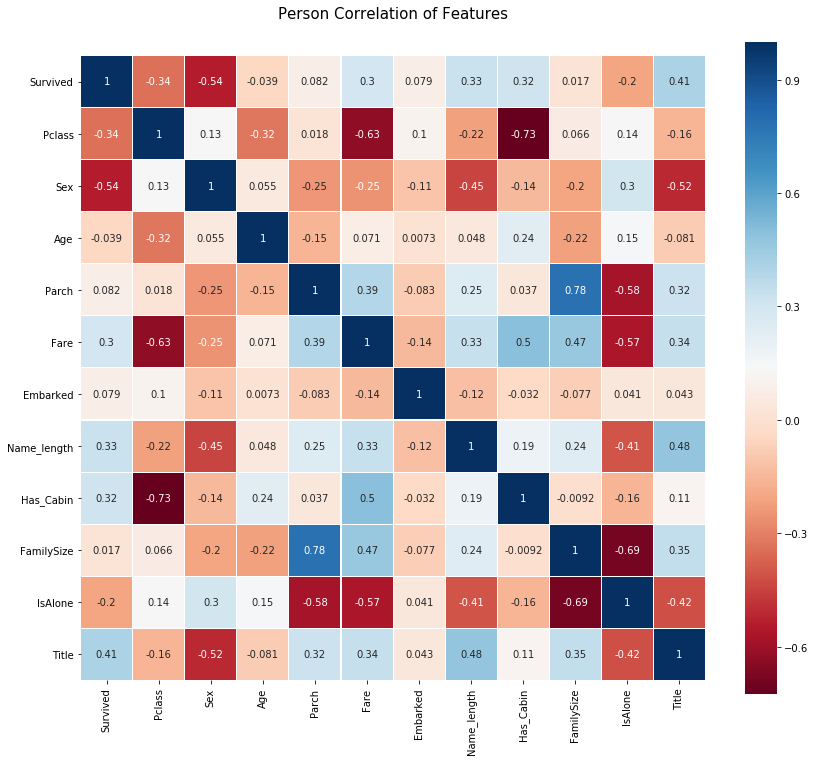

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
# corr(method='pearson', min_periods=1) method of pandas.core.frame.DataFrame instance
#     Compute pairwise correlation of columns, excluding NA/null values

# heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
#     Plot rectangular data as a color-encoded matrix.
    
#     This is an Axes-level function and will draw the heatmap into the
#     currently-active Axes if none is provided to the ``ax`` argument.  Part of
#     this Axes space will be taken and used to plot a colormap, unless ``cbar``
#     is False or a separate Axes is provided to ``cbar_ax``.
#    data : rectangular dataset
#         2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
#         is provided, the index/column information will be used to label the
#         columns and rows.
#     vmin, vmax : floats, optional
#         Values to anchor the colormap, otherwise they are inferred from the
#         data and other keyword arguments.
#     cmap : matplotlib colormap name or object, or list of colors, optional
#         The mapping from data values to color space. If not provided, the
#         default will depend on whether ``center`` is set.
#     square : boolean, optional
#         If True, set the Axes aspect to "equal" so each cell will be
#         square-shaped.
#     annot : bool or rectangular dataset, optional
#         If True, write the data value in each cell. If an array-like with the
#         same shape as ``data``, then use this to annotate the heatmap instead
#         of the raw data.
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True)

In [12]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

In [13]:
help(train.astype(float).corr)

Help on method corr in module pandas.core.frame:

corr(method='pearson', min_periods=1) method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'}
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid result. Currently only available for pearson
        and spearman correlation
    
    Returns
    -------
    y : DataFrame



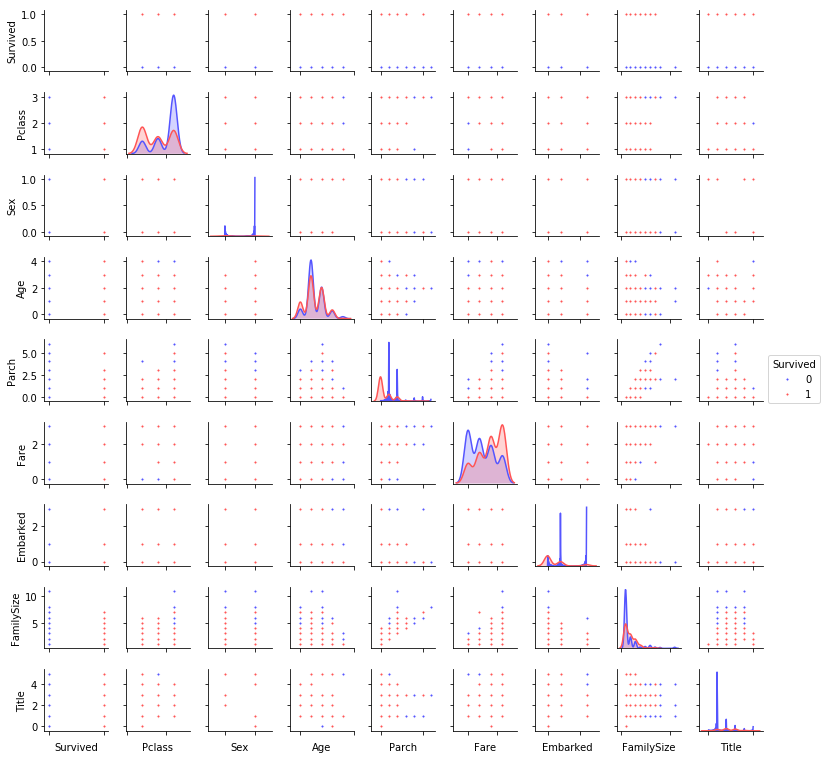

In [14]:
# pairplot(data, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='hist', markers=None, size=2.5, aspect=1, dropna=True, plot_kws=None, diag_kws=None, grid_kws=None)
#     Plot pairwise relationships in a dataset.
    
#     By default, this function will create a grid of Axes such that each
#     variable in ``data`` will by shared in the y-axis across a single row and
#     in the x-axis across a single column. The diagonal Axes are treated
#     differently, drawing a plot to show the univariate distribution of the data
#     for the variable in that column.
    
#     It is also possible to show a subset of variables or plot different
#     variables on the rows and columns.
    
#     This is a high-level interface for :class:`PairGrid` that is intended to
#     make it easy to draw a few common styles. You should use :class:`PairGrid`
#     directly if you need more flexibility.
    
#     Parameters
#     ----------
#     data : DataFrame
#         Tidy (long-form) dataframe where each column is a variable and
#         each row is an observation.
#     hue : string (variable name), optional
#         Variable in ``data`` to map plot aspects to different colors.
#     palette : dict or seaborn color palette
#         Set of colors for mapping the ``hue`` variable. If a dict, keys
#         should be values  in the ``hue`` variable.
#     diag_kind : {'hist', 'kde'}, optional
#         Kind of plot for the diagonal subplots.
#      {plot, diag, grid}_kws : dicts, optional
#         Dictionaries of keyword arguments.
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                       u'FamilySize', u'Title']], hue = 'Survived', palette = 'seismic', size = 1.2, diag_kind = 'kde', 
                 diag_kws = dict(shade = True), plot_kws = dict(s = 10))
g.set(xticklabels = [])

In [15]:
help(sns.pairplot)

Help on function pairplot in module seaborn.axisgrid:

pairplot(data, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='hist', markers=None, size=2.5, aspect=1, dropna=True, plot_kws=None, diag_kws=None, grid_kws=None)
    Plot pairwise relationships in a dataset.
    
    By default, this function will create a grid of Axes such that each
    variable in ``data`` will by shared in the y-axis across a single row and
    in the x-axis across a single column. The diagonal Axes are treated
    differently, drawing a plot to show the univariate distribution of the data
    for the variable in that column.
    
    It is also possible to show a subset of variables or plot different
    variables on the rows and columns.
    
    This is a high-level interface for :class:`PairGrid` that is intended to
    make it easy to draw a few common styles. You should use :class:`PairGrid`
    directly if you need more flexibility.
    
    Paramete

In [16]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

In [17]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [18]:
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' : 0
}

et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators' : 500,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [19]:
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC, seed = SEED, params = svc_params)

In [20]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis = 1)
x_train = train.values
x_test = test.values

In [21]:
help(train['Survived'].ravel)

KeyError: 'Survived'

In [23]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')

Training is complete


In [24]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.12605677 0.19973109 0.0320769  0.02213554 0.07173075 0.02386851
 0.10592471 0.06511123 0.06875486 0.01344835 0.27116128]
[0.12273449 0.38803438 0.02999098 0.01667761 0.05614502 0.02648523
 0.0474582  0.08621928 0.04308699 0.02274544 0.16042237]
[0.032 0.012 0.018 0.068 0.04  0.01  0.686 0.014 0.05  0.004 0.066]
[0.0710408  0.02039328 0.11402004 0.03300855 0.09246863 0.05436437
 0.39559946 0.01901905 0.07425307 0.02560058 0.10023217]


In [25]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [26]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({
    'features' : cols,
    'Random Forest feature importances' : rf_features,
    'Extra Trees feature importances' : et_features,
    'AdaBoost feature importances' : ada_features,
    'Gradient Boost feature importances' : gb_features
})

In [27]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [28]:
# Random Forest
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    market = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest feature importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

# Extra Trees
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importances',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

# AdaBoost
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'AdaBoost Feature Importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

# Gradient Boost
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boost Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'scatter2010')

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'market'

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, *scatter* traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on plot.ly for  customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            plotly.graph_objs.scatter.ErrorX instance or dict with
            compatible properties
        error_y
            plotly.graph_objs.scatter.ErrorY instance or dict with
            compatible properties
        fill
            Sets the area to fill with a solid color. Use with
            `fillcolor` if not *none*. *tozerox* and *tozeroy* fill
            to x=0 and y=0 respectively. *tonextx* and *tonexty*
            fill between the endpoints of this trace and the
            endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like *tozerox* and *tozeroy*. *toself* connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. *tonext* fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            *toself* if there is no trace before it. *tonext*
            should not be used if one trace does not enclose the
            other.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on plot.ly for  hoverinfo .
        hoverlabel
            plotly.graph_objs.scatter.Hoverlabel instance or dict
            with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is *toself* or *tonext* and there
            are no markers or text, then the default is *fills*,
            otherwise it is *points*.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a *text* flag.
        hovertextsrc
            Sets the source reference on plot.ly for  hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on plot.ly for  ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        line
            plotly.graph_objs.scatter.Line instance or dict with
            compatible properties
        marker
            plotly.graph_objs.scatter.Marker instance or dict with
            compatible properties
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes *text* then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points, then the default is *lines+markers*.
            Otherwise, *lines*.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        r
            For legacy polar chart only.Please switch to
            *scatterpolar* trace type.Sets the radial coordinates.
        rsrc
            Sets the source reference on plot.ly for  r .
        selected
            plotly.graph_objs.scatter.Selected instance or dict
            with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            plotly.graph_objs.scatter.Stream instance or dict with
            compatible properties
        t
            For legacy polar chart only.Please switch to
            *scatterpolar* trace type.Sets the angular coordinates.
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a *text* flag and
            *hovertext* is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on plot.ly for  textposition
            .
        textsrc
            Sets the source reference on plot.ly for  text .
        tsrc
            Sets the source reference on plot.ly for  t .
        uid

        unselected
            plotly.graph_objs.scatter.Unselected instance or dict
            with compatible properties
        visible
            Determines whether or not this trace is visible. If
            *legendonly*, the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If *x* (the default value), the
            x coordinates refer to `layout.xaxis`. If *x2*, the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xsrc
            Sets the source reference on plot.ly for  x .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If *y* (the default value), the
            y coordinates refer to `layout.yaxis`. If *y2*, the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ysrc
            Sets the source reference on plot.ly for  y .
        

In [29]:
feature_dataframe['mean'] = feature_dataframe.mean(axis = 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [32]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
        x = x,
        y = y,
        width = 0.5,
        marker = dict(
            color = feature_dataframe['mean'].values,
            colorscale = 'Portland',
            showscale = True,
            reversescale = False
        ),
        opacity = 0.6
    )]

layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')

In [33]:
base_predictions_train = pd.DataFrame({
    'RandomForest' : rf_oof_train.ravel(),
    'ExtraTrees' : et_oof_train.ravel(),
    'AdaBoost' : ada_oof_train.ravel(),
    'GradientBoost' : gb_oof_train.ravel()
})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [37]:
rf_oof_train.shape

(891, 1)

In [39]:
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
        colorscale = 'Viridis',
        showscale = True,
        reversescale = True
    )
]
py.iplot(data, filename = 'labelled-heatmap')

In [41]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train
                        ), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test
                        ), axis = 1)

In [42]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [43]:
stackingSubmission = pd.DataFrame({
    'PassengerId' : PassengerId,
    'Survived' : predictions
})
stackingSubmission.to_csv('StackingSubmission.csv', index = False)